# A Plot of $k_{obs}$ vs. $\%H_2SO_4$ or $H_0$

This code will create the figure 2 in the discussion that plots $k_{obs}$ vs. $\% H_2SO_4$ and $\log{k_{obs}}$ vs $0.62H_0$ 

In [8]:
###################################################
### Create Interpolation Function for H0 from %H2SO4
###################################################

### This function below could be in an external library that you call in your own program.

def MakeInterpolationFunctionForH0inH2SO4byPercentWt():
    Data_File_Name = "02_H0_H2SO4_Tickle_1970.csv"

    import pandas as pd
    import numpy as np
    from scipy.interpolate import make_smoothing_spline               # A function for interpolating a plot using a Bspline algorithm. Returns an interpolation function.
    
    #github_location = "https://raw.githubusercontent.com/blinkletter/4410PythonNotebooks/main/Class_30/data/"
    github_location = "./data/"
        
    Filename = github_location + Data_File_Name
    
    df = pd.read_csv(Filename, 
                     delimiter = ",", 
                     skipinitialspace=True, 
                     comment = "#") 
    
    
    x = df["%H2SO4"]
    y = df["H0"]
    
    interpolation = make_smoothing_spline(x, y,      ### The x and y data
                                          w=None,    ### A list of weights for each point (default = None)
                                          lam=0.1)  ### A factor for the degree of smoothing. Change this to change the smoothness.
    
    return(interpolation)

###################################################
### call the function to create an interpolator for activity H2O in H2SO4
###################################################

interpolator = MakeInterpolationFunctionForH0inH2SO4byPercentWt()

###################################################
### An example of using the inerpolation function that you just created
###################################################

percentH2SO4 = 100

H0Value = interpolator(percentH2SO4)

#print(f"The H0 in {percentH2SO4}% H2SO4 is {H0Value:0.3f}")


In [9]:
##############################################################
### Set up libraries and global variables
##############################################################

Data_File_Name = "Yates_Table1.csv"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import curve_fit
from scipy.stats import linregress

from statsmodels.nonparametric.smoothers_lowess import lowess     # A function for interpolating a plot using the locally weighed scatterplot smoothing method. Returns smoothed x,y points
from scipy.interpolate import CubicSpline                         # A function for interpolating a plot using the cubic spline method. Returns an interpolation function.
from scipy.interpolate import interp1d                            # A function for interpolating a plot using the connect-the-dots method. Returns an interpolation function.
from scipy.interpolate import make_smoothing_spline               # A function for interpolating a plot using a Bspline algorithm. Returns an interpolation function.

from matplotlib.patches import PathPatch
from matplotlib.path import Path


#github_location = "https://raw.githubusercontent.com/blinkletter/4410PythonNotebooks/main/Class_30/data/"
github_location = "./data/"
github_H0_location = "https://raw.githubusercontent.com/blinkletter/4410PythonNotebooks/main/Class_08/data/H0_data/"
github_location_styles = "https://raw.githubusercontent.com/blinkletter/LFER-QSAR/main/styles/"
github_location_LFER_tables = "https://raw.githubusercontent.com/blinkletter/LFER-QSAR/main/data/"

molwtH2SO4 = 98.08
molwtH20 = 18.0
densityH2SO4 = 1.83
densityH2O = 1.000

### interpolation = interp1d(x1, y1, kind='linear')
### interpolation = CubicSpline(x1, y1)
### interpolation = scipy.interpolate.make_smoothing_spline(x1, y1, w=None, lam=0.03)



In [32]:
##############################################################
### Import the data and perform calculations
##############################################################

Filename = github_location + Data_File_Name

df = pd.read_csv(Filename, 
                 delimiter = ",", 
                 skipinitialspace=True, 
#                 index_col="Substituent", 
                 comment = "#") 

df1 = (df.loc[df['Ester'] == 'MeOAc'])   ### Select only the MeOAc data

#display(df1)

interpolator = MakeInterpolationFunctionForH0inH2SO4byPercentWt()
df1["H0"] = interpolator(df1["PercentH2SO4"])

m = 0.62
df1["HS"] = df1["H0"] * m

df1["log_k_obs"] = np.log10(df1["kobs"]) - 2

display(df1)


/var/folders/3h/d_p2gtjd78g8c7m6c14chsg00000gq/T/ipykernel_48878/4062599778.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1["H0"] = interpolator(df1["PercentH2SO4"])
/var/folders/3h/d_p2gtjd78g8c7m6c14chsg00000gq/T/ipykernel_48878/4062599778.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1["HS"] = df1["H0"] * m
/var/folders/3h/d_p2gtjd78g8c7m6c14chsg00000gq/T/ipykernel_48878/4062599778.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

,Ester,PercentH2SO4,kobs,H0,HS,log_k_obs
0,MeOAc,14.1,1.500,-0.597414,-0.370397,-1.823909
1,MeOAc,20.7,2.610,-1.040195,-0.644921,-1.583359
2,MeOAc,28.3,4.220,-1.509841,-0.936101,-1.374688
3,MeOAc,34.8,6.410,-2.000013,-1.240008,-1.193142
4,MeOAc,40.4,8.140,-2.419997,-1.500398,-1.089376
5,MeOAc,45.4,10.400,-2.794364,-1.732506,-0.982967
6,MeOAc,50.2,11.400,-3.232965,-2.004438,-0.943095
7,MeOAc,55.2,13.300,-3.780673,-2.344017,-0.876148
8,MeOAc,60.4,13.800,-4.399864,-2.727916,-0.860121
9,MeOAc,65.2,11.900,-4.997463,-3.098427,-0.924453


[14.1 20.7 28.3 34.8 40.4 45.4 50.2 55.2 60.4 65.2 70.4 74.1 80. ]


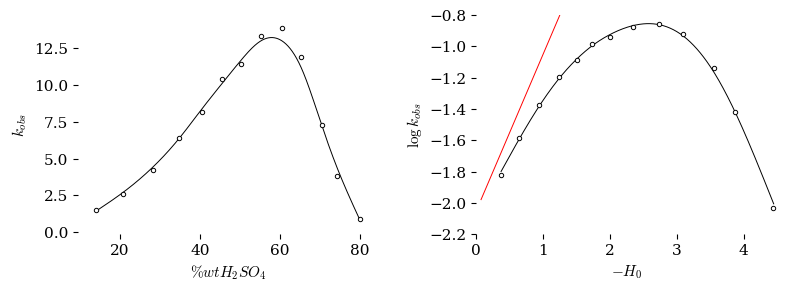

In [82]:
###################################################
### Get the data
###################################################

x = df1["PercentH2SO4"]
y = df1["kobs"]

x1 = -df1["HS"]
y1 = df1["log_k_obs"]

###################################################
### Interpolate the data
###################################################

### Using a smoothing interpolation function that returns a Bspline function

if True:
       y_lowess = lowess(y, 
                         x, 
                         frac=1/3, 
                         it=3, 
                         delta=0.0, 
                         xvals=None, 
                         is_sorted=False, 
                         missing='drop', 
                         return_sorted=True)

print(y_lowess[:,0])

interpolation = make_smoothing_spline(y_lowess[:,0], y_lowess[:,1],      ### The x and y data
                                      w=None,    ### A list of weights for each point (default = None)
                                      lam=1)  ### A factor for the degree of smoothing. Change this to change the smoothness.

step = 0.01
x_smooth = np.arange(np.min(x), np.max(x)+step, step)
y_smooth = interpolation(x_smooth)

interpolation1 = make_smoothing_spline(x1, y1,      ### The x and y data
                                       w=None,    ### A list of weights for each point (default = None)
                                       lam=0.03)  ### A factor for the degree of smoothing. Change this to change the smoothness.
step = 0.01
x1_smooth = np.arange(np.min(x1), np.max(x1)+step, step)
y1_smooth = interpolation1(x1_smooth)


###################################################
### Set zoom range for second plot
###################################################

#zoom_xlim=[80,100]; zoom_ylim=[7,11]
#zoom_xlim=[0,20]; zoom_ylim=[None, None]
zoom_xlim=[0,20]; zoom_ylim=[-1.5, 1]
#zoom_xlim=[80,100]; zoom_ylim=[15, 21]




###################################################
### Set up labels for plots
###################################################

x_label = "$\%wt {H_2SO_4}$"
y_label = "$k_{obs}$"

x1_label = "$-H_0$"
y1_label = "$\log{k_{obs}}$"


Title0 = "$H_0$ vs. %wt $H_2SO_4$"
Title0HR = "$H_R$ vs. %wt $H_2SO_4$"

Title1 = "Expanded Region"

###################################################
### Create figure for plot
###################################################

style = "tufte.mplstyle"
#style = "S2_classic2.mplstyle"
style_name = github_location_styles + style
plt.style.use(style_name)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,3))  

###################################################
### Make the first plot (plot 0)
###################################################

ax[0].set(
#          title = Title0,       
          ylabel=y_label, 
          xlabel=x_label,                
#          xlim=[-.9,.9],                  
#          ylim=[-3.7,-2.7]
       )
ax[0].margins(x=.07, y=.07, tight=True)

# ax[0].axvline(x=30, ymin=0.1, ymax = 0.9, linewidth = 0.5, color = "lightgray", zorder = 0)   # A vertical line highlight

if True:
       ax[0].scatter(x, y, 
                    marker = "o", 
                    s = 10, 
                    color = "white", 
                    edgecolors = "black", 
                    linewidths=0.7, 
                    zorder = 2)


#ax[0].plot(x, y, "-", color = "black", linewidth=0.7, zorder = 1)
ax[0].plot(x_smooth, y_smooth, "-", color = "black", linewidth=0.7, zorder = 1)


###################################################
### Make the second plot (plot 1)
###################################################

ax[1].set(
#          title = Title1,       
          ylabel=y1_label, 
          xlabel=x1_label,                
          xlim=[0,4.5],      ### Set axis limits to zoom in         
          ylim=[-2.2,-0.8]
       )
ax[1].margins(x=.07, y=.07, tight=True)

# ax[1].axvline(x=30, ymin=0.1, ymax = 0.9, linewidth = 0.5, color = "lightgray", zorder = 0)   # A vertical line highlight

ax[1].scatter(x1, y1, 
              marker = "o", 
              s = 10, 
              color = "white", 
              edgecolors = "black", 
              linewidths=0.7, 
              zorder = 2)


#ax[1].plot(x, y, "-", color = "black", linewidth=0.7, zorder = 1)
ax[1].plot(x1_smooth, y1_smooth, "-", color = "black", linewidth=0.7, zorder = 1)
ax[1].plot(x1-.3, x1-2.35, "-", color = "red", linewidth=0.7, zorder = 1)

plt.savefig("fig2.pdf")
plt.show()





In [36]:
###################################################
### Create Interpolation Function for H0 from %H2SO4
###################################################

### This function below could be in an external library that you call in your own program.

def MakeInterpolationFunctionForH0inH2SO4byPercentWt():
    Data_File_Name = "02_H0_H2SO4_Tickle_1970.csv"

    import pandas as pd
    import numpy as np
    from scipy.interpolate import make_smoothing_spline               # A function for interpolating a plot using a Bspline algorithm. Returns an interpolation function.
    
    #github_location = "https://raw.githubusercontent.com/blinkletter/4410PythonNotebooks/main/Class_30/data/"
    github_location = "./data/"
        
    Filename = github_location + Data_File_Name
    
    df = pd.read_csv(Filename, 
                     delimiter = ",", 
                     skipinitialspace=True, 
                     comment = "#") 
    
    
    x = df["%H2SO4"]
    y = df["H0"]
    
    interpolation = make_smoothing_spline(x, y,      ### The x and y data
                                          w=None,    ### A list of weights for each point (default = None)
                                          lam=0.1)  ### A factor for the degree of smoothing. Change this to change the smoothness.
    
    return(interpolation)

###################################################
### call the function to create an interpolator for activity H2O in H2SO4
###################################################

interpolator = MakeInterpolationFunctionForH0inH2SO4byPercentWt()

###################################################
### An example of using the inerpolation function that you just created
###################################################

percentH2SO4 = 100

H0Value = interpolator(percentH2SO4)

print(f"The H0 in {percentH2SO4}% H2SO4 is {H0Value:0.3f}")


The H0 in 100% H2SO4 is -10.616


In [55]:
###################################################
### Create Interpolation Function for HR from %H2SO4
###################################################

### This function below could be in an external library that you call in your own program.

def MakeInterpolationFunctionForHRinH2SO4byPercentWt():
    Data_File_Name = "04_Deno_1955_HR_Values.csv"

    import pandas as pd
    import numpy as np
    from scipy.interpolate import make_smoothing_spline               # A function for interpolating a plot using a Bspline algorithm. Returns an interpolation function.
    
    #github_location = "https://raw.githubusercontent.com/blinkletter/4410PythonNotebooks/main/Class_30/data/"
    github_location = "./data/"
        
    Filename = github_location + Data_File_Name
    
    df = pd.read_csv(Filename, 
                     delimiter = ",", 
                     skipinitialspace=True, 
                     comment = "#") 
    
    
    x = df["%H2SO4"]
    y = df["HR"]
    
    interpolation = make_smoothing_spline(x, y,      ### The x and y data
                                          w=None,    ### A list of weights for each point (default = None)
                                          lam=0.1)  ### A factor for the degree of smoothing. Change this to change the smoothness.
    
    return(interpolation)

###################################################
### call the function to create an interpolator for activity H2O in H2SO4
###################################################

interpolator = MakeInterpolationFunctionForHRinH2SO4byPercentWt()

###################################################
### An example of using the inerpolation function that you just created
###################################################

percentH2SO4 = 100

H0Value = interpolator(percentH2SO4)

print(f"The HR in {percentH2SO4}% H2SO4 is {H0Value:0.3f}")

The HR in 100% H2SO4 is -20.752


LinregressResult(slope=1.9030498577417443, intercept=0.2876147288744839, rvalue=0.9989514585552143, pvalue=5.926569878654264e-66, stderr=0.012588647911204376, intercept_stderr=0.06649812864101028)


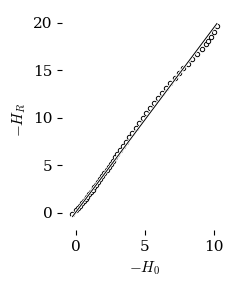

In [73]:
##################################################
### Apply interpolation function to get HR at the same concentrations as were used in the H0 data
##################################################

dfH0HR = dfH0.copy()
interpolator = MakeInterpolationFunctionForHRinH2SO4byPercentWt()
dfH0HR["HR"] = interpolator(dfH0HR["%H2SO4"])

x = -dfH0HR["H0"]
y = -dfH0HR["HR"]

#x = -dfH0HR["H0"]
#y = -dfH0HR["HR"]



###################################################
### Set up labels for plots
###################################################

x_label = "$-H_0$"
y_label = "$-H_R$"

Title = "$H_R$ vs. $H_0$"

###################################################
### Create figure for plot
###################################################

style = "tufte.mplstyle"
#style = "S2_classic2.mplstyle"
style_name = github_location_styles + style
plt.style.use(style_name)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(2.5,3)) 

###################################################
### Make the plot
###################################################

ax.set(
#          title = Title,       
          ylabel=y_label, 
          xlabel=x_label,                
#          xlim=[-.9,.9],                  
#          ylim=[-3.7,-2.7]
       )
ax.margins(x=.07, y=.07, tight=True)

if True:
       ax.scatter(x, y, 
                    marker = "o", 
                    s = 10, 
                    color = "white", 
                    edgecolors = "black", 
                    linewidths=0.7, 
                    zorder = 2)


#ax.plot(x, y, "-", color = "black", linewidth=0.7, zorder = 1)
#ax.plot(x_smooth, y_smooth, "-", color = "black", linewidth=0.7, zorder = 1)

###################################################
### Linear regression
###################################################


def func(x, slope):
       y = x*slope
       return(y)

popt, pcov = curve_fit(func, x, y)
slope = popt[0]
y1 = x * slope


#fit = linregress(x,y)
#y1 = x*fit.slope + fit.intercept
ax.plot(x, y1, "-", color = "white", linewidth=2, zorder = 2)
ax.plot(x, y1, "-", color = "black", linewidth=0.7, zorder = 2)


plt.savefig("H0HrCorrelation.pdf")
plt.show()

In [28]:
df1["kobs"]

KeyError: 'kobs'